In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle

# ✅ Paths (Update to your dataset path)
DATASET_DIR = "C:/Users/uppal/OneDrive/Desktop/a/images"
IMG_SIZE = 224  
BATCH_SIZE = 32  

# ✅ Check if dataset exists
if not os.path.exists(DATASET_DIR):
    raise ValueError(f"Dataset directory '{DATASET_DIR}' not found!")

def load_images(folder, label):
    """Loads images from a folder and assigns a label (0 = real, 1 = fake)."""
    images, labels = [], []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # Convert BGR to RGB
            images.append(img)
            labels.append(label)
    
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

# ✅ Load images from "real" and "fake" folders
real_images, real_labels = load_images(os.path.join(DATASET_DIR, "real"), label=0)
fake_images, fake_labels = load_images(os.path.join(DATASET_DIR, "fake"), label=1)

# ✅ Combine and shuffle dataset
X = np.concatenate((real_images, fake_images), axis=0)
y = np.concatenate((real_labels, fake_labels), axis=0)
X, y = shuffle(X, y, random_state=42)

# ✅ Normalize images (ResNet expects values in [-1,1] range)
X = (X / 127.5) - 1.0

# ✅ Split into train (80%), val (10%), test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ✅ Convert labels to categorical (for softmax)
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# ✅ Create TensorFlow dataset pipeline
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ✅ Print dataset sizes
print(f"✅ Preprocessing complete! Loaded dataset from '{DATASET_DIR}'")
print(f"Real images: {len(real_images)} | Fake images: {len(fake_images)}")
print(f"Training: {X_train.shape[0]} | Validation: {X_val.shape[0]} | Testing: {X_test.shape[0]}")


✅ Preprocessing complete! Loaded dataset from 'C:/Users/uppal/OneDrive/Desktop/a/images'
Real images: 900 | Fake images: 900
Training: 1440 | Validation: 180 | Testing: 180


In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import AdamW


# ✅ Learning rate schedule (Cosine Decay)
def cosine_decay(epoch):
    initial_lr = 0.005
    return float(initial_lr * 0.5 * (1 + tf.math.cos(epoch / 50 * 3.1416)))  # Ensure float output  # 50 epochs

# ✅ ResNet Block
def resnet_block(inputs, filters, kernel_size=3, stride=1):
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, kernel_size, strides=1, padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same",
                             kernel_regularizer=regularizers.l2(1e-4))(inputs)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# ✅ ResNet-50 Model
def build_resnet50(input_shape=(224, 224, 3), num_classes=2):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding="same", kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # Adding ResNet blocks (50 layers total)
    filter_sizes = [64, 128, 256, 512]
    num_blocks = [3, 4, 6, 3]  # Adjust to reach 50 layers

    for filters, blocks in zip(filter_sizes, num_blocks):
        for i in range(blocks):
            stride = 2 if i == 0 else 1
            x = resnet_block(x, filters, stride=stride)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Increase dropout to avoid overfitting
    x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.6)(x)  # Higher dropout to further regularize
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    return model

# ✅ Compile Model
model = build_resnet50()
model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=1e-4),  # Replacing Lookahead + Adam
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


# ✅ Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_scheduler = keras.callbacks.LearningRateScheduler(cosine_decay)

# ✅ Model Checkpoint (Save best model when val_loss decreases)
checkpoint_filepath = "resnet50_2_model.h5"
model_checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor="val_loss", save_best_only=True, verbose=1
)

# ✅ Train Model
history = model.fit(
    train_data, validation_data=val_data, epochs=50,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)

# ✅ Load Best Model & Evaluate
best_model = keras.models.load_model(checkpoint_filepath)
test_loss, test_acc = best_model.evaluate(test_data)

print(f"✅ Best Model Saved at Val Loss: {min(history.history['val_loss']):.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4865 - loss: 3.3134
Epoch 1: val_loss improved from inf to 11912350720.00000, saving model to resnet50_2_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 270s 5s/step - accuracy: 0.4871 - loss: 3.3212 - val_accuracy: 0.5000 - val_loss: 11912350720.0000 - learning_rate: 0.0050
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5576 - loss: 3.6328
Epoch 2: val_loss improved from 11912350720.00000 to 256946.17188, saving model to resnet50_2_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 220s 5s/step - accuracy: 0.5570 - loss: 3.6343 - val_accuracy: 0.5000 - val_loss: 256946.1719 - learning_rate: 0.0050
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5489 - loss: 3.2075
Epoch 3: val_loss improved from 256946.17188 to 78.70725, saving model to resnet50_2_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 220s 5s/step - accuracy: 0.5488 - loss: 3.2059 - val_accuracy: 0.5000 - val_loss: 78.7073 - learning_rate: 0.0050
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5108 - loss: 2.7987
Epoch 4: val_loss improved from 78.70725 to 2.56564, saving model to resnet50_2_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 222s 5s/step - accuracy: 0.5113 - loss: 2.7962 - val_accuracy: 0.4000 - val_loss: 2.5656 - learning_rate: 0.0050
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5872 - loss: 2.3791
Epoch 5: val_loss improved from 2.56564 to 2.23180, saving model to resnet50_2_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 218s 5s/step - accuracy: 0.5885 - loss: 2.3771 - val_accuracy: 0.5222 - val_loss: 2.2318 - learning_rate: 0.0049
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6525 - loss: 2.1255
Epoch 6: val_loss improved from 2.23180 to 2.02775, saving model to resnet50_2_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 222s 5s/step - accuracy: 0.6528 - loss: 2.1241 - val_accuracy: 0.6333 - val_loss: 2.0277 - learning_rate: 0.0049
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7528 - loss: 1.8547
Epoch 7: val_loss did not improve from 2.02775
45/45 ━━━━━━━━━━━━━━━━━━━━ 255s 5s/step - accuracy: 0.7530 - loss: 1.8534 - val_accuracy: 0.5278 - val_loss: 2.2695 - learning_rate: 0.0048
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7604 - loss: 1.6912
Epoch 8: val_loss improved from 2.02775 to 1.90403, saving model to resnet50_2_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 225s 5s/step - accuracy: 0.7602 - loss: 1.6916 - val_accuracy: 0.5944 - val_loss: 1.9040 - learning_rate: 0.0048
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7387 - loss: 1.6021
Epoch 9: val_loss improved from 1.90403 to 1.51598, saving model to resnet50_2_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 222s 5s/step - accuracy: 0.7393 - loss: 1.6009 - val_accuracy: 0.7500 - val_loss: 1.5160 - learning_rate: 0.0047
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8096 - loss: 1.3931
Epoch 10: val_loss improved from 1.51598 to 1.47110, saving model to resnet50_2_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 220s 5s/step - accuracy: 0.8096 - loss: 1.3926 - val_accuracy: 0.5111 - val_loss: 1.4711 - learning_rate: 0.0046
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8045 - loss: 1.3413
Epoch 11: val_loss improved from 1.47110 to 1.32817, saving model to resnet50_2_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 218s 5s/step - accuracy: 0.8041 - loss: 1.3413 - val_accuracy: 0.7500 - val_loss: 1.3282 - learning_rate: 0.0045
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8093 - loss: 1.2171
Epoch 12: val_loss did not improve from 1.32817
45/45 ━━━━━━━━━━━━━━━━━━━━ 222s 5s/step - accuracy: 0.8094 - loss: 1.2170 - val_accuracy: 0.5556 - val_loss: 3.3177 - learning_rate: 0.0044
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7958 - loss: 1.2079
Epoch 13: val_loss did not improve from 1.32817
45/45 ━━━━━━━━━━━━━━━━━━━━ 221s 5s/step - accuracy: 0.7961 - loss: 1.2072 - val_accuracy: 0.5000 - val_loss: 6.0184 - learning_rate: 0.0043
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8493 - loss: 1.0519
Epoch 14: val_loss did not improve from 1.32817
45/45 ━━━━━━━━━━━━━━━━━━━━ 227s 5s/step - accuracy: 0.8492 - loss: 1.0517 - val_accuracy: 0.5000 - val_loss: 2.7881 - learning_rate: 0.0042
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5s

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7277 - loss: 1.3889 
✅ Best Model Saved at Val Loss: 1.3282
Test Accuracy: 0.7222


In [1]:
from tensorflow.keras.models import load_model

# ✅ Load the best saved model
model = load_model("resnet50_2_model.h5")

# ✅ Print model summary to confirm it's loaded correctly
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_118 (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_118       │ (None, 112, 112, 64)      │             256 │ conv2d_118[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_66 (ReLU)               │ (None, 112, 112, 64)      │               0 │ batch_normalization_118[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 56, 56, 64)        │               0 │ re_lu_66[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_119 (Conv2D)           │ (None, 28, 28, 64)        │          36,928 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_119       │ (None, 28, 28, 64)        │             256 │ conv2d_119[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_67 (ReLU)               │ (None, 28, 28, 64)        │               0 │ batch_normalization_119[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_120 (Conv2D)           │ (None, 28, 28, 64)        │          36,928 │ re_lu_67[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_121 (Conv2D)           │ (None, 28, 28, 64)        │           4,160 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_120       │ (None, 28, 28, 64)        │             256 │ conv2d_120[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_121       │ (None, 28, 28, 64)        │             256 │ conv2d_121[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_40 (Add)                  │ (None, 28, 28, 64)        │               0 │ batch_normalization_120[0… │
│                               │                           │                 │ batch_normalization_121[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_68 (ReLU)               │ (None, 28, 28, 64)        │               0 │ add_40[0][0]               │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 22,501,700 (85.84 MB)

 Trainable params: 22,478,914 (85.75 MB)

 Non-trainable params: 22,784 (89.00 KB)

 Optimizer params: 2 (12.00 B)

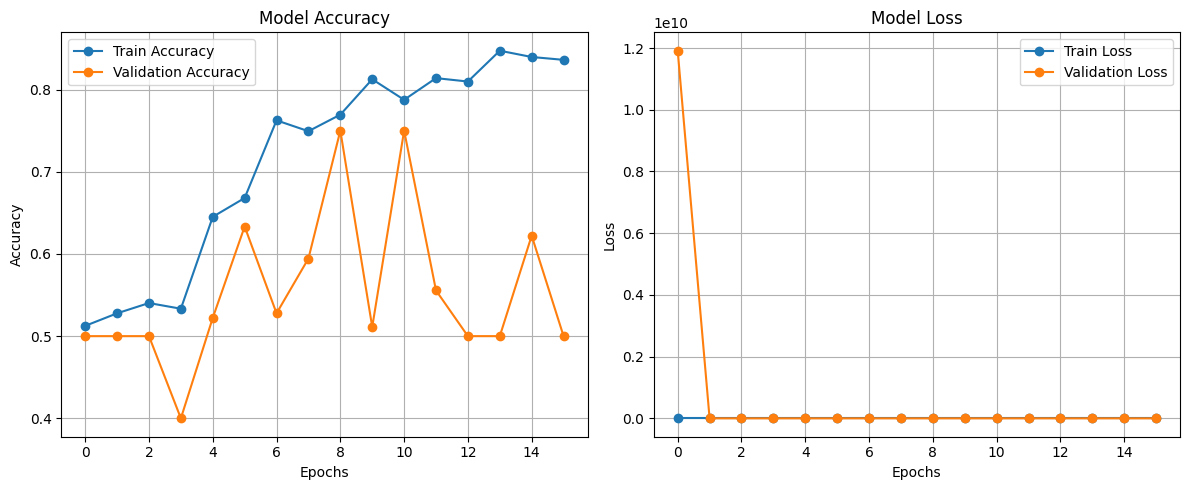

In [32]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """Plot training & validation accuracy and loss."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # ✅ Accuracy Plot
    ax[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].legend()
    ax[0].grid(True)

    # ✅ Loss Plot
    ax[1].plot(history.history['loss'], label='Train Loss', marker='o')
    ax[1].plot(history.history['val_loss'], label='Validation Loss', marker='o')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Model Loss')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

# ✅ Call function after training
plot_training_history(history)


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step  
After adjustment: y_test shape = (180,), y_pred shape = (180,)
📊 Classification Report:
               precision    recall  f1-score   support

        Real       0.96      0.89      0.92        90
        Fake       0.90      0.97      0.93        90

    accuracy                           0.93       180
   macro avg       0.93      0.93      0.93       180
weighted avg       0.93      0.93      0.93       180



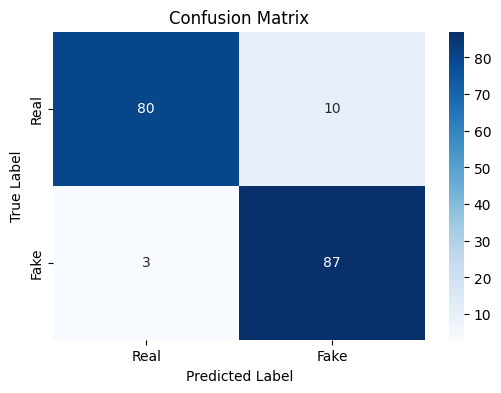

In [33]:
def evaluate_model(model, X_test, y_test, threshold=0.5):
    # ✅ Predict probabilities
    y_pred_probs = model.predict(X_test)

    # ✅ Extract probability of "Fake" class if shape is (N,2)
    if y_pred_probs.shape[1] == 2:  
        y_pred_probs = y_pred_probs[:, 1]  # Take probability of class 1 (Fake)
    
    # ✅ Convert probabilities to binary predictions
    y_pred = (y_pred_probs > threshold).astype(int)

    print(f"After adjustment: y_test shape = {y_test.shape}, y_pred shape = {y_pred.shape}")

    # ✅ Print classification report
    print("📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=["Real", "Fake"]))

    # ✅ Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# ✅ Call function to evaluate model
evaluate_model(model, X_test, y_test)


In [6]:
import numpy as np
import cv2
import tensorflow as tf

# ✅ Load trained model
model = tf.keras.models.load_model("resnet50_2_model.h5")  # Ensure this file exists

# ✅ Preprocess a new image
def preprocess_image(image_path, img_size=224):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_size, img_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = img / 127.5 - 1.0  # Normalize to [-1,1]
    return np.expand_dims(img, axis=0)  # Add batch dimension

# ✅ Predict function
def predict_image(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)[0][0]  # Get the probability
    label = "Fake" if prediction > 0.5 else "Real"
    print(f"Prediction: {label} (Confidence: {prediction:.4f})")

# ✅ Test with a sample image
predict_image(r"C:\Users\uppal\OneDrive\Desktop\a\f1.png")  # Replace with actual image path


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Fake (Confidence: 0.7068)
